<a href="https://colab.research.google.com/github/rituparrna33/Failed-order-analysis-of-Gett-cab-app/blob/main/Insights_from_failed_orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

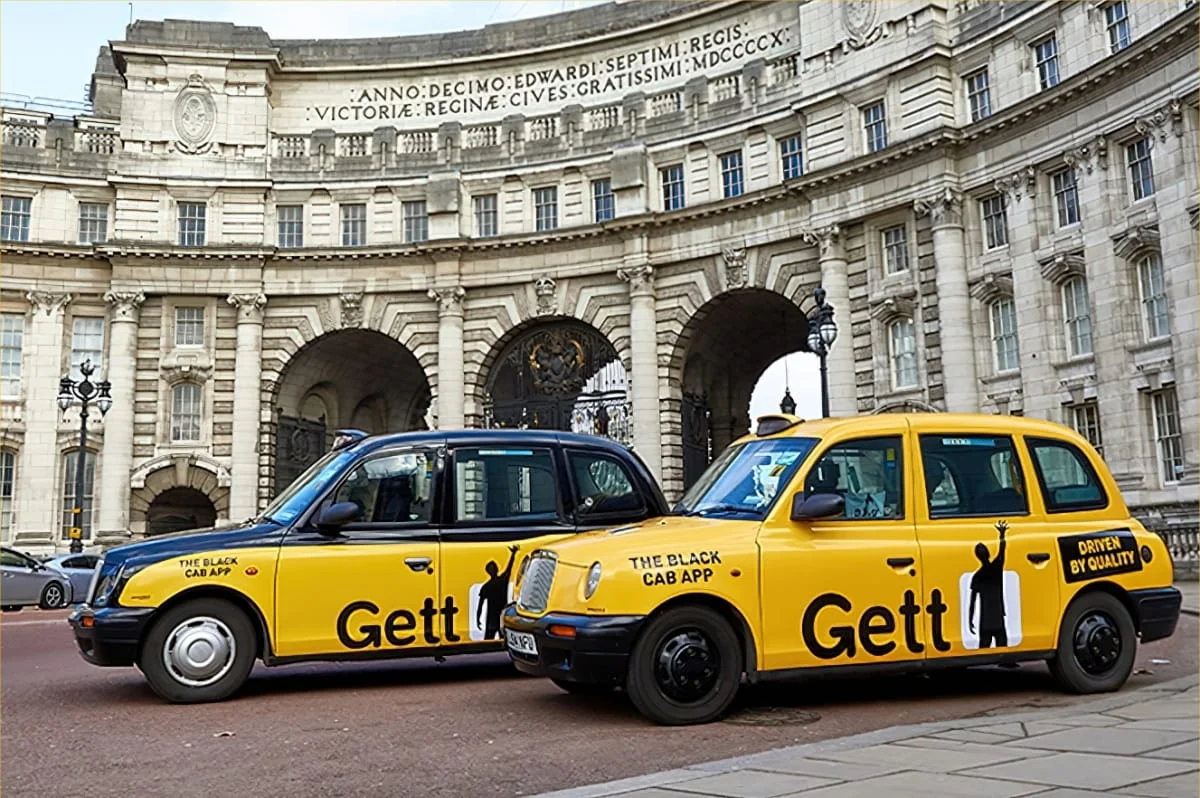


Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

#Analysis Objectives


Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

Plot the distribution of average ETA by hours. How can this plot be explained?
BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

#Data Description
We have two data sets: data_orders and data_offers, both being stored in a CSV format. The data_orders data set contains the following columns:

order_datetime - time of the order
origin_longitude - longitude of the order
origin_latitude - latitude of the order
m_order_eta - time before order arrival
order_gk - order number
order_status_key - status, an enumeration consisting of the following mapping:
4 - cancelled by client,
9 - cancelled by system, i.e., a reject
is_driver_assigned_key - whether a driver has been assigned
cancellation_time_in_seconds - how many seconds passed before cancellation
The data_offers data set is a simple map with 2 columns:

order_gk - order number, associated with the same column from the orders data set
offer_id - ID of an offer



In [90]:
##importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
datetime.now()

datetime.datetime(2023, 2, 6, 23, 30, 49, 899103)

In [3]:
#importing the data files
offers = pd.read_csv("data_offers.csv")
orders = pd.read_csv("data_orders.csv")


In [9]:
#Navigating Offers dataframe
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [10]:
#Navigating Orders dataframe
offers.head()
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [23]:
offers.shape #334363, 2
orders.shape# 10716, 8

# orders less than offers? 1 order matched with multiple offers?

(10716, 8)

In [63]:
#merging the two tables inner or left? inner join and left join giving different numbers
df=orders.merge(offers, on='order_gk',how='inner' )
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275


I may be able to do something to improve the data quality a bit. For example, the values in order_status_key and is_driver_assigned_key are not informative of the contents but are rather just keys that point to some internal description. I replace their values with more informative information, like replacing the 1s in is_driver_assigned_key with the string Yes and the 0s with the string No. The same can be done for the order_status_key column. Moreover, the names of the columns sound a bit technical, but we can modify them.

In [64]:
df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Yes", "No")
df["order_status"] = np.where(df["order_status_key"] == 4, "Client Cancelled", "System Reject")

df.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace=True)

In [65]:
df = df.rename(columns={
    "order_datetime": "order_time"
})

In [66]:
df = df.rename(columns={
    "cancellations_time_in_seconds": "cancelld_secs"
})

In [67]:
df.head()

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancelld_secs,offer_id,is_driver_assigned,order_status
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,198.0,300050983403,Yes,Client Cancelled
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986179,No,Client Cancelled
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986174,No,Client Cancelled
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986180,No,Client Cancelled
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,46.0,300050976275,Yes,Client Cancelled


## Question 1:Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

One, straightforward solution to solve this question is to use the groupby method to group the DataFrame by the is_driver_assigned and order_status columns, and then count the rows in each group, i.e., each combination of values for the grouping columns.

Since both are binary variables (have only two possible values), there are four possible combinations. The cell below prints the output of the proposed approach.

We observe a high number of orders cancelled before a driver is assigned, implying that maybe customers have waited too long and have decided on an alternative for their transportation needs. We have 13435 orders cancelled by the client, and 9469 rejected by the system. There are 8360 client cancellations after a driver has been assigned, and only four which were rejected by the system, for some reason.

In [68]:
df.groupby(['is_driver_assigned','order_status'])['order_gk'].count()

is_driver_assigned  order_status    
No                  Client Cancelled    13435
                    System Reject        9469
Yes                 Client Cancelled     8360
                    System Reject           4
Name: order_gk, dtype: int64

In [70]:
#average cancellation time 

df.groupby(['is_driver_assigned'])['cancelld_secs'].mean()



is_driver_assigned
No     120.313956
Yes    233.845694
Name: cancelld_secs, dtype: float64

In [81]:
#with pivot table
df_q1 = df.pivot_table(columns=["is_driver_assigned", "order_status"], values="order_gk", aggfunc="count")
df_q1

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_gk                      13435          9469             8360   

is_driver_assigned                
order_status       System Reject  
order_gk                       4

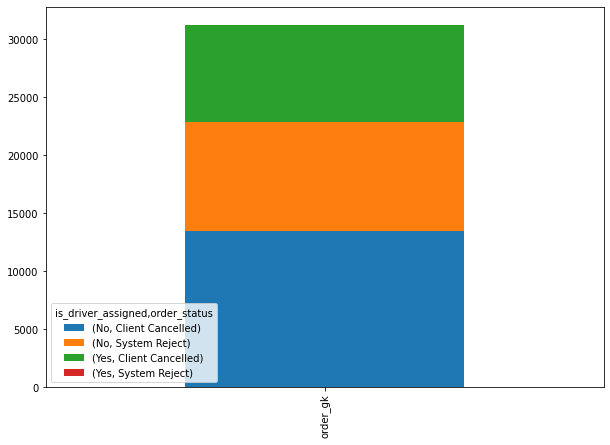

In [85]:
df_q1.plot(kind="bar",stacked=True,figsize=(10, 7))
plt.show()

# Question 2
Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

This question builds up upon the previous one by delving deeper into the analysis of failed orders. Rather than just plotting the distribution of fails by category (reason for cancellation, and the driver assignment), we want to know when these fails occur, and if there is some specific period in the day when one category prevails over others.

In [87]:
# extract hour from the time column
df["order_hour"] = df["order_time"].str.split(":").apply(lambda split: split[0])

In [88]:
df.head()

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancelld_secs,offer_id,is_driver_assigned,order_status,order_hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,198.0,300050983403,Yes,Client Cancelled,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986179,No,Client Cancelled,20
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986174,No,Client Cancelled,20
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986180,No,Client Cancelled,20
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,46.0,300050976275,Yes,Client Cancelled,12


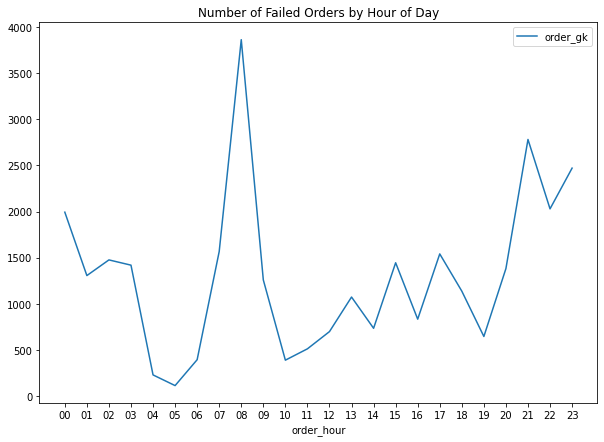

In [97]:
df.groupby('order_hour')['order_gk'].count().plot(kind='line',figsize=(10, 7),
                                                         legend=True,
                                                         xticks=range(0, 24),
                                                         title="Number of Failed Orders by Hour of Day")
#maximum failed orders at 8 am? followed by between 9 to 10pm

1. clean
2. join
3. remove/impute values
4. categorise, filter, groupby
5. visualise

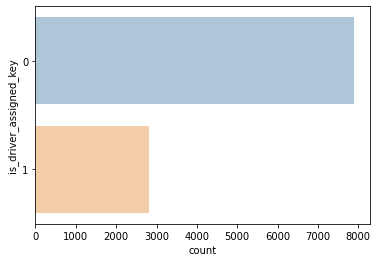

In [ ]:
sns.countplot(y=orders["is_driver_assigned_key"], alpha=0.4)

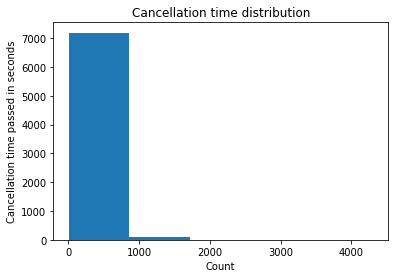

In [ ]:
plt.hist(orders['cancellations_time_in_seconds'],bins=5)
xlab = 'Count'
ylab = 'Cancellation time passed in seconds'
title = 'Cancellation time distribution'

# Add axis labels
plt.xlabel(xlab)
plt.ylabel(ylab)

# Add title
plt.title(title)
plt.show()


In [ ]:
orders["cancellations_time_in_seconds"].describe()

count    7307.000000
mean      157.892021
std       213.366963
min         3.000000
25%        45.000000
50%        98.000000
75%       187.500000
max      4303.000000
Name: cancellations_time_in_seconds, dtype: float64

In [ ]:
datajoined= offers.merge(orders)